In [1]:
import warnings
warnings.filterwarnings('ignore')
import classyRF_final as classyRF
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pathData = "C:\\Users\\marin\\Desktop\\ML_workingGroup\\allEOS\\"
pathForest = "C:\\Users\\marin\\Desktop\\ML_workingGroup\\FINAL\\SushantForest_2\\"
pathMDC = "C:\\Users\\marin\\Desktop\\ML_workingGroup\\FINAL\\"
pathMarcoFiles = "C:\\Users\\marin\\Desktop\\ML_workingGroup\\FINAL\\MarcoFiles\\"
EOS = ["APR4_EPP", "BHF_BBB2", "H4", "HQC18", "KDE0V", "KDE0V1", "MPA1", "MS1_PP", "MS1B_PP", "RS", "SK255", "SK272", "SKI2", "SKI3", "SKI4", "SKI5", "SKI6", "SKMP", "SKOP", "SLy", "SLY2", "SLY9", "SLY230A"]
BayesFactor=[1.526, 1.555, 0.056, 1.422, 1.177, 1.283, 0.276, 0.001, 0.009, 0.176, 0.179, 0.159, 0.108, 0.107, 0.33, 0.025, 0.288, 0.29, 0.618, 1.0, 1.028, 0.37, 0.932]
EOSTest = ["APR4_EPP", "BHF_BBB2"]
EOScolor = ['BHF_BBB2', 'SLy', 'MS1B_PP']
color_v = ['orange', 'green', 'blue']

i_m1r=1; i_m2r=2; i_x1r=3; i_x2r=4; i_snr=8;
recovered=[i_m1r, i_m2r, i_x1r, i_x2r, i_snr]
#header of the test file:
#ID,m1_rec,m2_rec,chi1_rec,chi2_rec,mc_rec,q_rec,R_isco_rec,snr,s

In [3]:
# Plotting details
plt.rcParams["font.size"]=14
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True

In [72]:
###
#
# thr_points: the points to subdivide the probability space for the threshold (more points => smoother curve)
# prob_event: probability of the events of having the property (NS or REM), bayesian or from the classifier
# truth_events: true label of the events
# emb: property calculated: 'NS' or 'REM'
# thr_display: array of values where TP and FN is printed, to add as separate points in the plot
#
###

def calculate_ROC(thr_points, prob_events, truth_events, emb, thr_display):
    threshold = np.linspace(0,1,thr_points+1)
    TP = np.zeros(thr_points+1)
    FP = np.zeros(thr_points+1)
    if (emb=='REM'):
        events_have_emb = np.where(truth_events==2)[0]
    if (emb=='NS'):
        events_have_emb = np.where((truth_events==1) | (truth_events==2))[0]
    N = len(events_have_emb)
    M = len(truth_events) - N
    points = []
    i=0
    for thr in threshold:
        index_say_yes = np.where(prob_events>=thr)[0]
        count_yes = 0.0; count_no = 0.0
        for index in index_say_yes:
            if index in events_have_emb:
                count_yes = count_yes + 1.0
            else:
                count_no = count_no + 1.0
        TP[i] = count_yes/N
        FP[i] = count_no/M
        if (len(thr_display)>0 and (thr in thr_display)):
            print("Threshold ",thr, "TP: {:.3f}, FP {:.3f}".format(TP[i], FP[i]))
            points.append([thr, TP[i], FP[i]])
        i = i + 1
        
    return np.asarray(FP), np.asarray(TP), threshold, points
    
def plot_ROC_O2(forest, emb, ymin, xmax, legx, legy, save=False):
    plt.figure()
    maxfp = 0
    for eos in EOS:
        plt.plot(forest[eos]['FP_'+emb],forest[eos]['TP_'+emb],  c='grey', linewidth=0.3)
        mx = np.max(forest[eos]['FP_'+emb])
        if mx > maxfp:
            maxfp = mx
    colors = ['red','blue','green']
    markers = ['o', 'v', 's', 'P', 'D']
    for i,eos in enumerate(EOScolor):
        plt.plot(forest[eos]['FP_'+emb], forest[eos]['TP_'+emb], c=colors[i], label=eos)
        for k in range(0, len(forest[eos]['roc_'+emb+'_points'])):
            plt.scatter(forest[eos]['roc_'+emb+'_points'][k][2], forest[eos]['roc_'+emb+'_points'][k][1], marker=markers[k], c=colors[i])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    if emb=='NS':
        plt.title(r"\texttt{HasNS}")
    else:
        plt.title(r'\texttt{HasRem}')
    plt.grid(ls='--')
    plt.ylim([ymin,1.002])
    if xmax>0:
        maxfp=xmax
    plt.xlim([0, maxfp])
    points1 = plt.scatter(-1,0.9,c='blue',marker='o')
    points2 = plt.scatter(-1,0.9,c='blue',marker='v')
    points3 = plt.scatter(-1,0.9,c='blue',marker='s')
    legend1 = plt.legend([points1, points2, points3], ["0.1", "0.5", "0.9"], loc= (legx,legy), title="Threshold")
    plt.gca().add_artist(legend1)
    plt.legend(loc = 'lower right')
    #plt.yticks(np.linspace(0.825,1,8))
    if save:
        plt.savefig('ROC_O2testing_'+emb+'.png',dpi=200,bbox_inches='tight')
    plt.show()

In [ ]:
def calculate_ROC_KNN(thr_points, prob_events, truth_events, emb, thr_display):
    threshold = np.linspace(0,1,thr_points+1)
    TP = np.zeros(thr_points+1)
    FP = np.zeros(thr_points+1)
    if (emb=='REM'):
        events_have_emb = np.where(truth_events==2)[0]
    if (emb=='NS'):
        events_have_emb = np.where((truth_events==1) | (truth_events==2))[0]
    N = len(events_have_emb)
    M = len(truth_events) - N
    points = []
    i=0
    for thr in threshold:
        index_say_yes = np.where(prob_events>=thr)[0]
        count_yes = 0.0; count_no = 0.0
        for index in index_say_yes:
            if index in events_have_emb:
                count_yes = count_yes + 1.0
            else:
                count_no = count_no + 1.0
        TP[i] = count_yes/N
        FP[i] = count_no/M
        if (len(thr_display)>0 and (thr in thr_display)):
            print("Threshold ",thr, "TP: {:.3f}, FP {:.3f}".format(TP[i], FP[i]))
            points.append([thr, TP[i], FP[i]])
        i = i + 1
        
    return np.asarray(FP), np.asarray(TP), threshold, points
    
def plot_ROC_O2_KNN(knn, emb, ymin, xmax, legx, legy, save=False):
    plt.figure()
    maxfp = 0
    for eos in EOS:
        plt.plot(knn[eos]['FP_'+emb],knn[eos]['TP_'+emb],  c='grey', linewidth=0.3)
        mx = np.max(knn[eos]['FP_'+emb])
        if mx > maxfp:
            maxfp = mx
    colors = ['red','blue','green']
    markers = ['o', 'v', 's', 'P', 'D']
    for i,eos in enumerate(EOScolor):
        plt.plot(knn[eos]['FP_'+emb], knn[eos]['TP_'+emb], c=colors[i], label=eos)
        for k in range(0, len(knn[eos]['roc_'+emb+'_points'])):
            plt.scatter(knn[eos]['roc_'+emb+'_points'][k][2], knn[eos]['roc_'+emb+'_points'][k][1], marker=markers[k], c=colors[i])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    if emb=='NS':
        plt.title(r"\texttt{HasNS}")
    else:
        plt.title(r'\texttt{HasRem}')
    plt.grid(ls='--')
    plt.ylim([ymin,1.002])
    if xmax>0:
        maxfp=xmax
    plt.xlim([0, maxfp])
    points1 = plt.scatter(-1,0.9,c='blue',marker='o')
    points2 = plt.scatter(-1,0.9,c='blue',marker='v')
    points3 = plt.scatter(-1,0.9,c='blue',marker='s')
    legend1 = plt.legend([points1, points2, points3], ["0.1", "0.5", "0.9"], loc= (legx,legy), title="Threshold")
    plt.gca().add_artist(legend1)
    plt.legend(loc = 'lower right')
    #plt.yticks(np.linspace(0.825,1,8))
    if save:
        plt.savefig('ROC_O2testing_'+emb+'.png',dpi=200,bbox_inches='tight')
    plt.show()

# ROC curves in testing set
### algorithm probabilities, all EoS, three highlited (SLy (very accepted), max and min Mmax)

## RF

In [47]:
# CALCULATE
EOSdicRF = {}
count = 0
for eos in EOS:
    print('************'+eos+'**************')
    RF = classyRF.ClassificationRF()
    RF.loadPickle(pathForest+'random_forest_'+eos)
    new_dic = {}
    RF.load_test_dataset(pathData+eos+'\\EMB\\', 'test_EMB_ID_LABEL_'+eos+'_s300_f0d7.csv')
    new_dic['label_REM'] = RF.labels_test
    aux = RF.labels_test
    RF.load_test_dataset(pathData+eos+'\\NS\\', 'test_NS_ID_LABEL_'+eos+'_s300_f0d7.csv')
    new_dic['label_NS'] = RF.labels_test
    RF.labels_test = RF.labels_test + aux
    RF.subset_test(recovered)
    new_dic['forest'] = RF
    new_dic['weight'] = BayesFactor[count]
    EOSdicRF[eos] = new_dic
    probs = EOSdicRF[eos]['forest'].model.predict_proba(EOSdicRF[eos]['forest'].data_test)
    print('--HasNS--')
    EOSdicRF[eos]['FP_NS'], EOSdicRF[eos]['TP_NS'], \
        EOSdicRF[eos]['thr_NS'], EOSdicRF[eos]['roc_NS_points'] = \
        calculate_ROC(100, 1-probs[:, 0] ,
                      EOSdicRF[eos]['forest'].labels_test, 'NS', [0.1, 0.5, 0.9])
    print('--HasRem--')
    EOSdicRF[eos]['FP_REM'], EOSdicRF[eos]['TP_REM'], \
        EOSdicRF[eos]['thr_REM'], EOSdicRF[eos]['roc_REM_points'] = \
        calculate_ROC(100, probs[:,2],
                      EOSdicRF[eos]['forest'].labels_test, 'REM', [0.1, 0.5, 0.9])
    count = count + 1 

************APR4_EPP**************
--HasNS--
Threshold  0.1 TP: 0.999, FP 0.105
Threshold  0.5 TP: 0.993, FP 0.036
Threshold  0.9 TP: 0.937, FP 0.005
--HasRem--
Threshold  0.1 TP: 0.999, FP 0.012
Threshold  0.5 TP: 0.990, FP 0.002
Threshold  0.9 TP: 0.944, FP 0.000
************BHF_BBB2**************
--HasNS--
Threshold  0.1 TP: 0.999, FP 0.106
Threshold  0.5 TP: 0.994, FP 0.043
Threshold  0.9 TP: 0.929, FP 0.005
--HasRem--
Threshold  0.1 TP: 0.998, FP 0.011
Threshold  0.5 TP: 0.986, FP 0.002
Threshold  0.9 TP: 0.935, FP 0.000
************H4**************
--HasNS--
Threshold  0.1 TP: 0.999, FP 0.106
Threshold  0.5 TP: 0.993, FP 0.038
Threshold  0.9 TP: 0.934, FP 0.005
--HasRem--
Threshold  0.1 TP: 0.999, FP 0.022
Threshold  0.5 TP: 0.988, FP 0.006
Threshold  0.9 TP: 0.925, FP 0.001
************HQC18**************
--HasNS--
Threshold  0.1 TP: 1.000, FP 0.110
Threshold  0.5 TP: 0.994, FP 0.039
Threshold  0.9 TP: 0.933, FP 0.005
--HasRem--
Threshold  0.1 TP: 0.998, FP 0.013
Threshold  0.5 

KeyboardInterrupt: 

In [70]:
#OR LOAD
EOSdicRF = {}
count = 0
for eos in EOS:
    RF = classyRF.ClassificationRF()
    RF.loadPickle(pathForest+'random_forest_'+eos)
    new_dic = {}
    RF.load_test_dataset(pathData+eos+'\\EMB\\', 'test_EMB_ID_LABEL_'+eos+'_s300_f0d7.csv')
    new_dic['label_REM'] = RF.labels_test
    aux = RF.labels_test
    RF.load_test_dataset(pathData+eos+'\\NS\\', 'test_NS_ID_LABEL_'+eos+'_s300_f0d7.csv')
    new_dic['label_NS'] = RF.labels_test
    RF.labels_test = RF.labels_test + aux
    RF.subset_test(recovered)
    new_dic['forest'] = RF
    new_dic['weight'] = BayesFactor[count]
    
    dataNS = np.loadtxt('NS_ROC_'+eos+'.txt')
    dataREM = np.loadtxt('REM_ROC_'+eos+'.txt')
    new_dic['FP_NS'] = dataNS[0:99]
    new_dic['TP_NS'] = dataNS[99:198]
    new_dic['FP_REM'] = dataREM[0:99]
    new_dic['TP_REM'] = dataREM[99:198]
    EOSdicRF[eos] = new_dic
    EOSdicRF[eos]['roc_REM_points']= [[0.1,new_dic['TP_REM'][9], new_dic['FP_REM'][9]],
                                      [0.5,new_dic['TP_REM'][49], new_dic['FP_REM'][49]],
                                      [0.9,new_dic['TP_REM'][89],new_dic['FP_REM'][89]]]
    EOSdicRF[eos]['roc_NS_points']= [[0.1,new_dic['TP_NS'][9], new_dic['FP_NS'][9]],
                                      [0.5,new_dic['TP_NS'][49], new_dic['FP_NS'][49]],
                                      [0.9,new_dic['TP_NS'][89],new_dic['FP_NS'][89]]]

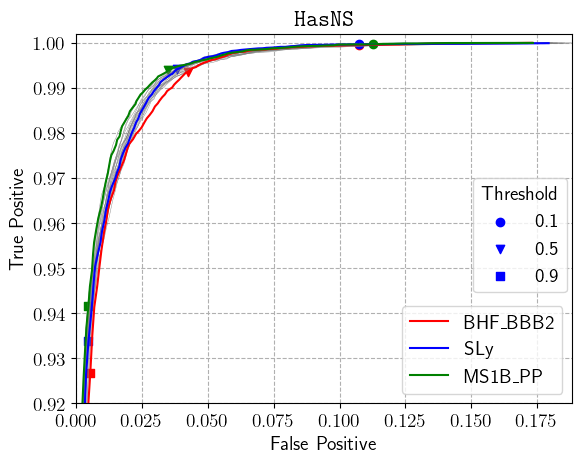

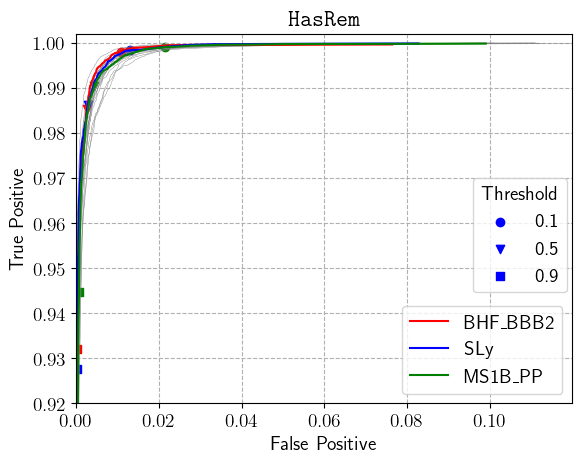

In [71]:
plot_ROC_O2(EOSdicRF, 'NS', ymin=0.92, xmax=-1, legx=0.8, legy=0.3,  save=True)
plot_ROC_O2(EOSdicRF, 'REM', ymin=0.92, xmax=-1, legx=0.8, legy=0.3, save=True)

## KNN

In [ ]:
pathClassy = "/Users/miquelmiravet/Projects/IPAM_LA/ML_group/KNN_miq/"
pathData = "/Users/miquelmiravet/Projects/IPAM_LA/ML_group/KNN_miq/input/"

In [ ]:
EOSdic = {}
count = 0

for eos in EOS:
    print("Doing", eos)
    KNN = KNNclassy.ClassificationKNN()
    KNN.load_train_dataset(pathData+eos+"/NS/train_NS_karoo_"+eos+"_s300_f0d7.csv",pathData+eos+"/EMB/train_EMB_karoo_"+eos+"_s300_f0d7.csv")
    KNN.load_test_dataset(pathData+eos+"/NS/test_NS_ID_LABEL_"+eos+"_s300_f0d7.csv",pathData+eos+"/EMB/test_EMB_ID_LABEL_"+eos+"_s300_f0d7.csv")
    KNN.loadModel(pathClassy+"optimal_models_final/", "knn_3cat_grid_eos_"+eos)
    new_dic = {}
    new_dic['knn'] = KNN
    new_dic['bayes'] = BayesFactor[count]
    EOSdic[eos] = new_dic
   
    KNN.compute_metrics()

    EOSdic[eos]['score'] = KNN.metrics['score']
    params_model = KNN.model.get_params()
    EOSdic[eos]['n_neigh'] = params_model.get('n_neighbors')
    EOSdic[eos]['metric'] = params_model.get('metric')
    EOSdic[eos]['algo'] = params_model.get('algorithm')
    EOSdic[eos]['weight'] = params_model.get('weights')
    
    probs = KNN.metrics["probab"]
    
    EOSdic[eos]['FP_NS'], EOSdic[eos]['TP_NS'], \
        EOSdic[eos]['thr_NS'], EOSdic[eos]['roc_NS_points'] = \
        calculate_ROC_KNN(100, 1-probs[:, 0] ,
                      EOSdic[eos]['knn'].label_test, 'NS', [0.1, 0.5, 0.9])
    print('--HasRem--')
    EOSdic[eos]['FP_REM'], EOSdic[eos]['TP_REM'], \
        EOSdic[eos]['thr_REM'], EOSdic[eos]['roc_REM_points'] = \
        calculate_ROC_KNN(100, probs[:,2],
                      EOSdic[eos]['knn'].label_test, 'REM', [0.1, 0.5, 0.9])
    count = count + 1 
    

In [ ]:
# Ajustar ymin para que se vea bien el gráfico, cuando te guste save=True
plot_ROC_O2_KNN(EOSdic, 'NS', ymin=0.92, xmax=-1, legx=0.8, legy=0.3,  save=False)
plot_ROC_O2_KNN(EOSdic, 'REM', ymin=0.92, xmax=-1, legx=0.8, legy=0.3, save=False)

# ROC curves in MDC11, bayesian probabilities

###  Marginalized, grouped by pipeline. Taken from Marco's Bayesian_probabilities_ROC_MDC11.ipynb

Calculation of FPR was wrong

### RF

In [4]:
from matplotlib.lines import Line2D
import pandas as pd

algorithm = 'RF'
precision = 4
p_events = pd.read_csv(pathMarcoFiles+algorithm+'_MDC_probabilities.csv',delimiter=',',index_col=False)

num_classifications = 50

display(p_events)

p_events_store = p_events

#cambiar a un color por pipeline
#y hay que hacer la extra con los thr 0.1, 0.5, 0.9
#custom_legend = [Line2D([], [], marker='o', markersize=12, linestyle='None'),
#          Line2D([], [], marker='+', markersize=12, linestyle='None'),
#          Line2D([], [], marker='x', markersize=12, linestyle='None'),
#          Line2D([], [], marker='*', markersize=12, linestyle='None'),
#          Line2D([], [], marker='D', markersize=12, linestyle='None')
#         ]


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\marin\\Desktop\\ML_workingGroup\\FINAL\\MarcoFiles\\RF_MDC_probabilities.csv'

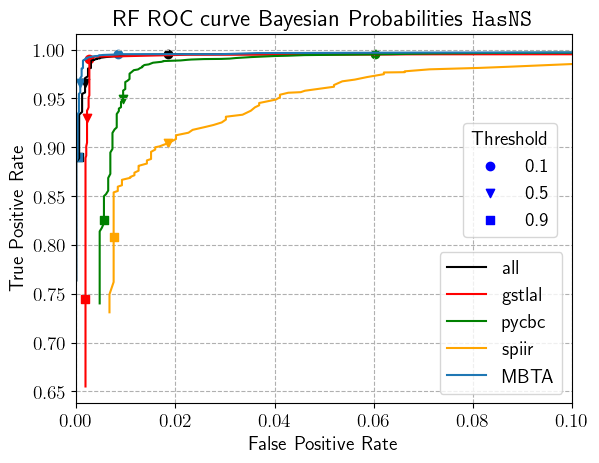

In [94]:
#fig = plt.figure(figsize=(12,10))
#ax = fig.add_subplot(111)
plt.figure()

plt.xlim([0,.1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(r"RF ROC curve Bayesian Probabilities \texttt{HasNS}")
plt.grid(ls='--')

TP = []
FP = []
points = []
for pns in np.linspace(0,1,101)[1:-1]:
    HasNS = p_events[p_events['HasNS_trueSLy']>0]
    non_HasNS = p_events[p_events['HasNS_trueSLy']<1]
    true_positives = HasNS[HasNS['P_NS']>=pns]
    false_positives = non_HasNS[non_HasNS['P_NS']>=pns]
    tpr = len(true_positives)/len(HasNS)
    fpr = len(false_positives)/len(non_HasNS) #fixed
    TP.append(tpr)
    FP.append(fpr)
    if (pns == 0.1 or pns == 0.5 or pns ==0.9):
        points.append([pns, fpr, tpr])
pns_roc = plt.plot(FP, TP, c='black', label='all')
plt.scatter(points[0][1], points[0][2],marker='o', c='black')
plt.scatter(points[1][1], points[1][2],marker='v', c='black')
plt.scatter(points[2][1], points[2][2],marker='s', c='black')

p_events = p_events_store[p_events_store['pipeline']=='gstlal']
TP = []
FP = [] 
points = []
for pns in np.linspace(0,1,101)[1:-1]:
    HasNS = p_events[p_events['HasNS_trueSLy']>0]
    non_HasNS = p_events[p_events['HasNS_trueSLy']<1]
    true_positives = HasNS[HasNS['P_NS']>=pns]
    false_positives = non_HasNS[non_HasNS['P_NS']>=pns]
    tpr = len(true_positives)/len(HasNS)
    fpr = len(false_positives)/len(non_HasNS)
    TP.append(tpr)
    FP.append(fpr)
    if (pns == 0.1 or pns == 0.5 or pns ==0.9):
        points.append([pns, fpr, tpr])
pns_roc = plt.plot(FP,TP,c='red', label='gstlal')
plt.scatter(points[0][1], points[0][2],marker='o', c='red')
plt.scatter(points[1][1], points[1][2],marker='v', c='red')
plt.scatter(points[2][1], points[2][2],marker='s', c='red')

p_events = p_events_store[p_events_store['pipeline']=='pycbc']
TP = []
FP = [] 
points = []
for pns in np.linspace(0,1,101)[1:-1]:
    HasNS = p_events[p_events['HasNS_trueSLy']>0]
    non_HasNS = p_events[p_events['HasNS_trueSLy']<1]
    true_positives = HasNS[HasNS['P_NS']>=pns]
    false_positives = non_HasNS[non_HasNS['P_NS']>=pns]
    tpr = len(true_positives)/len(HasNS)
    fpr = len(false_positives)/len(non_HasNS)
    TP.append(tpr)
    FP.append(fpr)
    if (pns == 0.1 or pns == 0.5 or pns ==0.9):
        points.append([pns, fpr, tpr])
pns_roc = plt.plot(FP,TP,c='green', label='pycbc')
plt.scatter(points[0][1], points[0][2],marker='o', c='green')
plt.scatter(points[1][1], points[1][2],marker='v', c='green')
plt.scatter(points[2][1], points[2][2],marker='s', c='green')

p_events = p_events_store[p_events_store['pipeline']=='spiir']
TP = []
FP = []   
points = []
for pns in np.linspace(0,1,101)[1:-1]:
    HasNS = p_events[p_events['HasNS_trueSLy']>0]
    non_HasNS = p_events[p_events['HasNS_trueSLy']<1]
    true_positives = HasNS[HasNS['P_NS']>=pns]
    false_positives = non_HasNS[non_HasNS['P_NS']>=pns]
    tpr = len(true_positives)/len(HasNS)
    fpr = len(false_positives)/len(non_HasNS)
    TP.append(tpr)
    FP.append(fpr)
    if (pns == 0.1 or pns == 0.5 or pns ==0.9):
        points.append([pns, fpr, tpr])
pns_roc = plt.plot(FP,TP,c='orange', label='spiir')
plt.scatter(points[0][1], points[0][2],marker='o', c='orange')
plt.scatter(points[1][1], points[1][2],marker='v', c='orange')
plt.scatter(points[2][1], points[2][2],marker='s', c='orange')

p_events = p_events_store[p_events_store['pipeline']=='MBTA']
TP = []
FP = []   
points = []    
for pns in np.linspace(0,1,101)[1:-1]:
    HasNS = p_events[p_events['HasNS_trueSLy']>0]
    non_HasNS = p_events[p_events['HasNS_trueSLy']<1]
    true_positives = HasNS[HasNS['P_NS']>=pns]
    false_positives = non_HasNS[non_HasNS['P_NS']>=pns]
    tpr = len(true_positives)/len(HasNS)
    fpr = len(false_positives)/len(HasNS)
    TP.append(tpr)
    FP.append(fpr)
    if (pns == 0.1 or pns == 0.5 or pns ==0.9):
        points.append([pns, fpr, tpr])
pns_roc = plt.plot(FP,TP,label='MBTA',c='#1f77b4')
plt.scatter(points[0][1], points[0][2],marker='o',c='#1f77b4')
plt.scatter(points[1][1], points[1][2],marker='v',c='#1f77b4')
plt.scatter(points[2][1], points[2][2],marker='s',c='#1f77b4')

points1 = plt.scatter(-1,0.9,c='blue',marker='o')
points2 = plt.scatter(-1,0.9,c='blue',marker='v')
points3 = plt.scatter(-1,0.9,c='blue',marker='s')
legend1 = plt.legend([points1, points2, points3], ["0.1", "0.5", "0.9"], loc= (0.78,0.45), title="Threshold")
plt.gca().add_artist(legend1)
plt.legend()
#plt.legend(custom_legend, ['All', 'gstlal', 'pycbc', 'spiir', 'MBTA'], loc='lower right', fontsize=15)
    
#plt.colorbar(pns_roc)
plt.savefig(algorithm+'_bayesian_NS.png',dpi=300, facecolor='w')
plt.show()

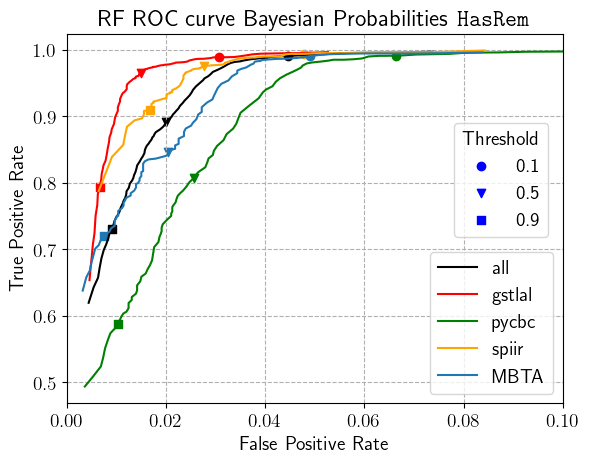

In [95]:
#fig = plt.figure(figsize=(12,10))
#ax = fig.add_subplot(111)
plt.figure()

plt.xlim([0,.1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(r"RF ROC curve Bayesian Probabilities \texttt{HasRem}")
plt.grid(ls='--')

TP = []
FP = []
points = []
for prem in np.linspace(0,1,101)[1:-1]:
    HasREM = p_events_store[p_events_store['HasREM_trueSLy']>0]
    non_HasREM = p_events_store[p_events_store['HasREM_trueSLy']<1]
    true_positives = HasREM[HasREM['P_REM']>=prem]
    false_positives = non_HasREM[non_HasREM['P_REM']>=prem]
    tpr = len(true_positives)/len(HasREM)
    fpr = len(false_positives)/len(non_HasREM) #fixed
    TP.append(tpr)
    FP.append(fpr)
    if (prem == 0.1 or prem == 0.5 or prem ==0.9):
        points.append([prem, fpr, tpr])
pns_roc = plt.plot(FP, TP, c='black', label='all')
plt.scatter(points[0][1], points[0][2],marker='o', c='black')
plt.scatter(points[1][1], points[1][2],marker='v', c='black')
plt.scatter(points[2][1], points[2][2],marker='s', c='black')

p_events = p_events_store[p_events_store['pipeline']=='gstlal']
TP = []
FP = [] 
points = []
for prem in np.linspace(0,1,101)[1:-1]:
    HasREM = p_events[p_events['HasREM_trueSLy']>0]
    non_HasREM = p_events[p_events['HasREM_trueSLy']<1]
    true_positives = HasREM[HasREM['P_REM']>=prem]
    false_positives = non_HasREM[non_HasREM['P_REM']>=prem]
    tpr = len(true_positives)/len(HasREM)
    fpr = len(false_positives)/len(non_HasREM) #fixed
    TP.append(tpr)
    FP.append(fpr)
    if (prem == 0.1 or prem == 0.5 or prem ==0.9):
        points.append([prem, fpr, tpr])
pns_roc = plt.plot(FP,TP,c='red', label='gstlal')
plt.scatter(points[0][1], points[0][2],marker='o', c='red')
plt.scatter(points[1][1], points[1][2],marker='v', c='red')
plt.scatter(points[2][1], points[2][2],marker='s', c='red')

p_events = p_events_store[p_events_store['pipeline']=='pycbc']
TP = []
FP = [] 
points = []
for prem in np.linspace(0,1,101)[1:-1]:
    HasREM = p_events[p_events['HasREM_trueSLy']>0]
    non_HasREM = p_events[p_events['HasREM_trueSLy']<1]
    true_positives = HasREM[HasREM['P_REM']>=prem]
    false_positives = non_HasREM[non_HasREM['P_REM']>=prem]
    tpr = len(true_positives)/len(HasREM)
    fpr = len(false_positives)/len(non_HasREM) #fixed
    TP.append(tpr)
    FP.append(fpr)
    if (prem == 0.1 or prem == 0.5 or prem ==0.9):
        points.append([prem, fpr, tpr])
pns_roc = plt.plot(FP,TP,c='green', label='pycbc')
plt.scatter(points[0][1], points[0][2],marker='o', c='green')
plt.scatter(points[1][1], points[1][2],marker='v', c='green')
plt.scatter(points[2][1], points[2][2],marker='s', c='green')

p_events = p_events_store[p_events_store['pipeline']=='spiir']
TP = []
FP = []   
points = []
for prem in np.linspace(0,1,101)[1:-1]:
    HasREM = p_events[p_events['HasREM_trueSLy']>0]
    non_HasREM = p_events[p_events['HasREM_trueSLy']<1]
    true_positives = HasREM[HasREM['P_REM']>=prem]
    false_positives = non_HasREM[non_HasREM['P_REM']>=prem]
    tpr = len(true_positives)/len(HasREM)
    fpr = len(false_positives)/len(non_HasREM) #fixed
    TP.append(tpr)
    FP.append(fpr)
    if (prem == 0.1 or prem == 0.5 or prem ==0.9):
        points.append([prem, fpr, tpr])
pns_roc = plt.plot(FP,TP,c='orange', label='spiir')
plt.scatter(points[0][1], points[0][2],marker='o', c='orange')
plt.scatter(points[1][1], points[1][2],marker='v', c='orange')
plt.scatter(points[2][1], points[2][2],marker='s', c='orange')

p_events = p_events_store[p_events_store['pipeline']=='MBTA']
TP = []
FP = []   
points = []
for prem in np.linspace(0,1,101)[1:-1]:
    HasREM = p_events[p_events['HasREM_trueSLy']>0]
    non_HasREM = p_events[p_events['HasREM_trueSLy']<1]
    true_positives = HasREM[HasREM['P_REM']>=prem]
    false_positives = non_HasREM[non_HasREM['P_REM']>=prem]
    tpr = len(true_positives)/len(HasREM)
    fpr = len(false_positives)/len(non_HasREM) #fixed
    TP.append(tpr)
    FP.append(fpr)
    if (prem == 0.1 or prem == 0.5 or prem ==0.9):
        points.append([prem, fpr, tpr])
pns_roc = plt.plot(FP,TP,label='MBTA',c='#1f77b4')
plt.scatter(points[0][1], points[0][2],marker='o',c='#1f77b4')
plt.scatter(points[1][1], points[1][2],marker='v',c='#1f77b4')
plt.scatter(points[2][1], points[2][2],marker='s',c='#1f77b4')

points1 = plt.scatter(-1,0.9,c='blue',marker='o')
points2 = plt.scatter(-1,0.9,c='blue',marker='v')
points3 = plt.scatter(-1,0.9,c='blue',marker='s')
legend1 = plt.legend([points1, points2, points3], ["0.1", "0.5", "0.9"], loc= (0.78,0.45), title="Threshold")
plt.gca().add_artist(legend1)
plt.legend()
#plt.legend(custom_legend, ['All', 'gstlal', 'pycbc', 'spiir', 'MBTA'], loc='lower right', fontsize=15)
    
#plt.colorbar(pns_roc)
plt.savefig(algorithm+'_bayesian_REM.png',dpi=300, facecolor='w')
plt.show()

### KNN

In [5]:
algorithm = 'KNN'
precision = 4
p_events = pd.read_csv(pathMarcoFiles+algorithm+'_MDC_probabilities.csv',delimiter=',',index_col=False)

num_classifications = 50

display(p_events)

p_events_store = p_events

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\marin\\Desktop\\ML_workingGroup\\FINAL\\MarcoFiles\\KNN_MDC_probabilities.csv'

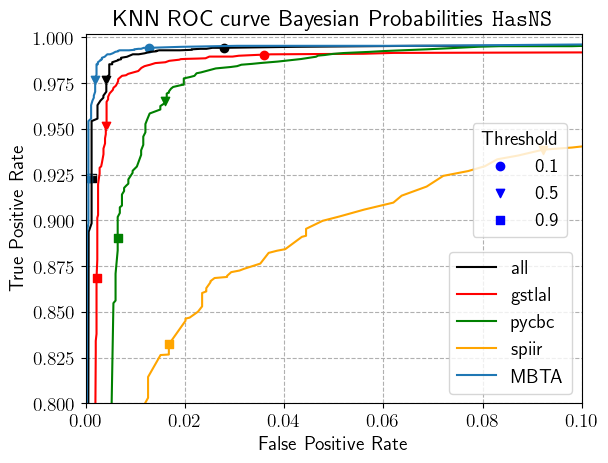

In [105]:
#fig = plt.figure(figsize=(12,10))
#ax = fig.add_subplot(111)
plt.figure()

plt.xlim([0,.1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(r"KNN ROC curve Bayesian Probabilities \texttt{HasNS}")
plt.grid(ls='--')

TP = []
FP = []
points = []
for pns in np.linspace(0,1,101)[1:-1]:
    HasNS = p_events[p_events['HasNS_true']>0]
    non_HasNS = p_events[p_events['HasNS_true']<1]
    true_positives = HasNS[HasNS['P_NS']>=pns]
    false_positives = non_HasNS[non_HasNS['P_NS']>=pns]
    tpr = len(true_positives)/len(HasNS)
    fpr = len(false_positives)/len(non_HasNS) #fixed
    TP.append(tpr)
    FP.append(fpr)
    if (pns == 0.1 or pns == 0.5 or pns ==0.9):
        points.append([pns, fpr, tpr])
pns_roc = plt.plot(FP, TP, c='black', label='all')
plt.scatter(points[0][1], points[0][2],marker='o', c='black')
plt.scatter(points[1][1], points[1][2],marker='v', c='black')
plt.scatter(points[2][1], points[2][2],marker='s', c='black')

p_events = p_events_store[p_events_store['pipeline']=='gstlal']
TP = []
FP = [] 
points = []
for pns in np.linspace(0,1,101)[1:-1]:
    HasNS = p_events[p_events['HasNS_true']>0]
    non_HasNS = p_events[p_events['HasNS_true']<1]
    true_positives = HasNS[HasNS['P_NS']>=pns]
    false_positives = non_HasNS[non_HasNS['P_NS']>=pns]
    tpr = len(true_positives)/len(HasNS)
    fpr = len(false_positives)/len(non_HasNS)
    TP.append(tpr)
    FP.append(fpr)
    if (pns == 0.1 or pns == 0.5 or pns ==0.9):
        points.append([pns, fpr, tpr])
pns_roc = plt.plot(FP,TP,c='red', label='gstlal')
plt.scatter(points[0][1], points[0][2],marker='o', c='red')
plt.scatter(points[1][1], points[1][2],marker='v', c='red')
plt.scatter(points[2][1], points[2][2],marker='s', c='red')

p_events = p_events_store[p_events_store['pipeline']=='pycbc']
TP = []
FP = [] 
points = []
for pns in np.linspace(0,1,101)[1:-1]:
    HasNS = p_events[p_events['HasNS_true']>0]
    non_HasNS = p_events[p_events['HasNS_true']<1]
    true_positives = HasNS[HasNS['P_NS']>=pns]
    false_positives = non_HasNS[non_HasNS['P_NS']>=pns]
    tpr = len(true_positives)/len(HasNS)
    fpr = len(false_positives)/len(non_HasNS)
    TP.append(tpr)
    FP.append(fpr)
    if (pns == 0.1 or pns == 0.5 or pns ==0.9):
        points.append([pns, fpr, tpr])
pns_roc = plt.plot(FP,TP,c='green', label='pycbc')
plt.scatter(points[0][1], points[0][2],marker='o', c='green')
plt.scatter(points[1][1], points[1][2],marker='v', c='green')
plt.scatter(points[2][1], points[2][2],marker='s', c='green')

p_events = p_events_store[p_events_store['pipeline']=='spiir']
TP = []
FP = []   
points = []
for pns in np.linspace(0,1,101)[1:-1]:
    HasNS = p_events[p_events['HasNS_true']>0]
    non_HasNS = p_events[p_events['HasNS_true']<1]
    true_positives = HasNS[HasNS['P_NS']>=pns]
    false_positives = non_HasNS[non_HasNS['P_NS']>=pns]
    tpr = len(true_positives)/len(HasNS)
    fpr = len(false_positives)/len(non_HasNS)
    TP.append(tpr)
    FP.append(fpr)
    if (pns == 0.1 or pns == 0.5 or pns ==0.9):
        points.append([pns, fpr, tpr])
pns_roc = plt.plot(FP,TP,c='orange', label='spiir')
plt.scatter(points[0][1], points[0][2],marker='o', c='orange')
plt.scatter(points[1][1], points[1][2],marker='v', c='orange')
plt.scatter(points[2][1], points[2][2],marker='s', c='orange')

p_events = p_events_store[p_events_store['pipeline']=='MBTA']
TP = []
FP = []   
points = []    
for pns in np.linspace(0,1,101)[1:-1]:
    HasNS = p_events[p_events['HasNS_true']>0]
    non_HasNS = p_events[p_events['HasNS_true']<1]
    true_positives = HasNS[HasNS['P_NS']>=pns]
    false_positives = non_HasNS[non_HasNS['P_NS']>=pns]
    tpr = len(true_positives)/len(HasNS)
    fpr = len(false_positives)/len(HasNS)
    TP.append(tpr)
    FP.append(fpr)
    if (pns == 0.1 or pns == 0.5 or pns ==0.9):
        points.append([pns, fpr, tpr])
pns_roc = plt.plot(FP,TP,label='MBTA',c='#1f77b4')
plt.scatter(points[0][1], points[0][2],marker='o',c='#1f77b4')
plt.scatter(points[1][1], points[1][2],marker='v',c='#1f77b4')
plt.scatter(points[2][1], points[2][2],marker='s',c='#1f77b4')

points1 = plt.scatter(-1,0.9,c='blue',marker='o')
points2 = plt.scatter(-1,0.9,c='blue',marker='v')
points3 = plt.scatter(-1,0.9,c='blue',marker='s')
legend1 = plt.legend([points1, points2, points3], ["0.1", "0.5", "0.9"], loc= (0.78,0.45), title="Threshold")
plt.gca().add_artist(legend1)
plt.legend()
#plt.legend(custom_legend, ['All', 'gstlal', 'pycbc', 'spiir', 'MBTA'], loc='lower right', fontsize=15)
#plt.colorbar(pns_roc)
plt.ylim(0.8,1.002)
plt.savefig(algorithm+'_bayesian_NS.png',dpi=300, facecolor='w')
plt.show()

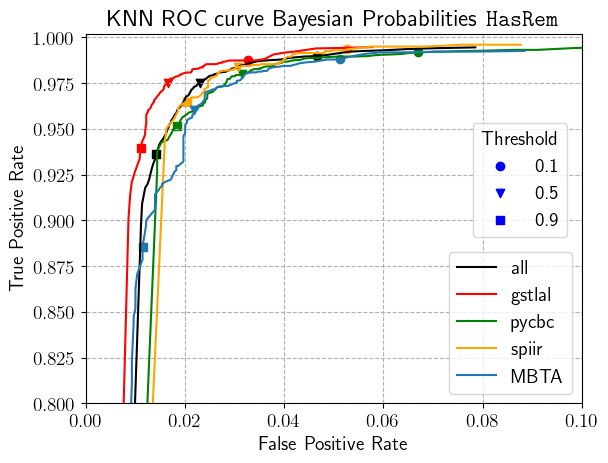

In [106]:
#fig = plt.figure(figsize=(12,10))
#ax = fig.add_subplot(111)
plt.figure()

plt.xlim([0,.1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(r"KNN ROC curve Bayesian Probabilities \texttt{HasRem}")
plt.grid(ls='--')

TP = []
FP = []
points = []
for prem in np.linspace(0,1,101)[1:-1]:
    HasREM = p_events_store[p_events_store['HasREM_true']>0]
    non_HasREM = p_events_store[p_events_store['HasREM_true']<1]
    true_positives = HasREM[HasREM['P_REM']>=prem]
    false_positives = non_HasREM[non_HasREM['P_REM']>=prem]
    tpr = len(true_positives)/len(HasREM)
    fpr = len(false_positives)/len(non_HasREM) #fixed
    TP.append(tpr)
    FP.append(fpr)
    if (prem == 0.1 or prem == 0.5 or prem ==0.9):
        points.append([prem, fpr, tpr])
pns_roc = plt.plot(FP, TP, c='black', label='all')
plt.scatter(points[0][1], points[0][2],marker='o', c='black')
plt.scatter(points[1][1], points[1][2],marker='v', c='black')
plt.scatter(points[2][1], points[2][2],marker='s', c='black')

p_events = p_events_store[p_events_store['pipeline']=='gstlal']
TP = []
FP = [] 
points = []
for prem in np.linspace(0,1,101)[1:-1]:
    HasREM = p_events[p_events['HasREM_true']>0]
    non_HasREM = p_events[p_events['HasREM_true']<1]
    true_positives = HasREM[HasREM['P_REM']>=prem]
    false_positives = non_HasREM[non_HasREM['P_REM']>=prem]
    tpr = len(true_positives)/len(HasREM)
    fpr = len(false_positives)/len(non_HasREM) #fixed
    TP.append(tpr)
    FP.append(fpr)
    if (prem == 0.1 or prem == 0.5 or prem ==0.9):
        points.append([prem, fpr, tpr])
pns_roc = plt.plot(FP,TP,c='red', label='gstlal')
plt.scatter(points[0][1], points[0][2],marker='o', c='red')
plt.scatter(points[1][1], points[1][2],marker='v', c='red')
plt.scatter(points[2][1], points[2][2],marker='s', c='red')

p_events = p_events_store[p_events_store['pipeline']=='pycbc']
TP = []
FP = [] 
points = []
for prem in np.linspace(0,1,101)[1:-1]:
    HasREM = p_events[p_events['HasREM_true']>0]
    non_HasREM = p_events[p_events['HasREM_true']<1]
    true_positives = HasREM[HasREM['P_REM']>=prem]
    false_positives = non_HasREM[non_HasREM['P_REM']>=prem]
    tpr = len(true_positives)/len(HasREM)
    fpr = len(false_positives)/len(non_HasREM) #fixed
    TP.append(tpr)
    FP.append(fpr)
    if (prem == 0.1 or prem == 0.5 or prem ==0.9):
        points.append([prem, fpr, tpr])
pns_roc = plt.plot(FP,TP,c='green', label='pycbc')
plt.scatter(points[0][1], points[0][2],marker='o', c='green')
plt.scatter(points[1][1], points[1][2],marker='v', c='green')
plt.scatter(points[2][1], points[2][2],marker='s', c='green')

p_events = p_events_store[p_events_store['pipeline']=='spiir']
TP = []
FP = []   
points = []
for prem in np.linspace(0,1,101)[1:-1]:
    HasREM = p_events[p_events['HasREM_true']>0]
    non_HasREM = p_events[p_events['HasREM_true']<1]
    true_positives = HasREM[HasREM['P_REM']>=prem]
    false_positives = non_HasREM[non_HasREM['P_REM']>=prem]
    tpr = len(true_positives)/len(HasREM)
    fpr = len(false_positives)/len(non_HasREM) #fixed
    TP.append(tpr)
    FP.append(fpr)
    if (prem == 0.1 or prem == 0.5 or prem ==0.9):
        points.append([prem, fpr, tpr])
pns_roc = plt.plot(FP,TP,c='orange', label='spiir')
plt.scatter(points[0][1], points[0][2],marker='o', c='orange')
plt.scatter(points[1][1], points[1][2],marker='v', c='orange')
plt.scatter(points[2][1], points[2][2],marker='s', c='orange')

p_events = p_events_store[p_events_store['pipeline']=='MBTA']
TP = []
FP = []   
points = []
for prem in np.linspace(0,1,101)[1:-1]:
    HasREM = p_events[p_events['HasREM_true']>0]
    non_HasREM = p_events[p_events['HasREM_true']<1]
    true_positives = HasREM[HasREM['P_REM']>=prem]
    false_positives = non_HasREM[non_HasREM['P_REM']>=prem]
    tpr = len(true_positives)/len(HasREM)
    fpr = len(false_positives)/len(non_HasREM) #fixed
    TP.append(tpr)
    FP.append(fpr)
    if (prem == 0.1 or prem == 0.5 or prem ==0.9):
        points.append([prem, fpr, tpr])
pns_roc = plt.plot(FP,TP,label='MBTA',c='#1f77b4')
plt.scatter(points[0][1], points[0][2],marker='o',c='#1f77b4')
plt.scatter(points[1][1], points[1][2],marker='v',c='#1f77b4')
plt.scatter(points[2][1], points[2][2],marker='s',c='#1f77b4')

points1 = plt.scatter(-1,0.9,c='blue',marker='o')
points2 = plt.scatter(-1,0.9,c='blue',marker='v')
points3 = plt.scatter(-1,0.9,c='blue',marker='s')
legend1 = plt.legend([points1, points2, points3], ["0.1", "0.5", "0.9"], loc= (0.78,0.45), title="Threshold")
plt.gca().add_artist(legend1)
plt.legend()
#plt.legend(custom_legend, ['All', 'gstlal', 'pycbc', 'spiir', 'MBTA'], loc='lower right', fontsize=15)
plt.ylim(0.8,1.002)

#plt.colorbar(pns_roc)
plt.savefig(algorithm+'_bayesian_REM.png',dpi=300, facecolor='w')
plt.show()